# Reconhecimento de marcas em imagens do twitter utilizando Azure

## Configurando o ambiente

In [1]:
!pip install tweepy
!pip install --upgrade azure-cognitiveservices-vision-computervision
!pip install pillow

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [49]:
import tweepy as tw
import json
from types import SimpleNamespace
import time
from azure.cognitiveservices.vision.computervision import ComputerVisionClient 
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes, Details
from IPython.display import Image

In [4]:
appsettings = {}

with open('appsettings.json') as f:
    appsettings = json.loads(f.read(), object_hook=lambda d: SimpleNamespace(**d))

In [5]:
auth = tw.OAuthHandler(appsettings.consumer_key, appsettings.consumer_secret)
auth.set_access_token(appsettings.access_token, appsettings.access_token_secret)

In [6]:
api = tw.API(auth)
tweet = api.update_status("Esse outro tweet foi feito através de um bot.")
tweet._json

{'created_at': 'Thu Dec 09 11:29:19 +0000 2021',
 'id': 1468905595470327809,
 'id_str': '1468905595470327809',
 'text': 'Esse outro tweet foi feito através de um bot.',
 'truncated': False,
 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []},
 'source': '<a href="https://github.com/SalatielBairros" rel="nofollow">PucDataRecovery</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 106542286,
  'id_str': '106542286',
  'name': 'Salatiel Bairros',
  'screen_name': 'SalatielB',
  'location': 'Porto Alegre, RS',
  'description': 'Cristão, marido, pai, desenvolvedor de software e apaixonado por teologia. Pós-graduando em Inteligência Artificial e Aprendizado de Máquina pela PUC-MG.',
  'url': 'https://t.co/lTLEmGx31v',
  'entities': {'url': {'urls': [{'url': 'https://t.co/lTLEmGx31v',
      'expanded_url': 'https://medium.com/salati

In [8]:
credentials = CognitiveServicesCredentials(appsettings.azure_key)
client = ComputerVisionClient(appsettings.azure_endpoint, credentials)
print(client.api_version)

3.2


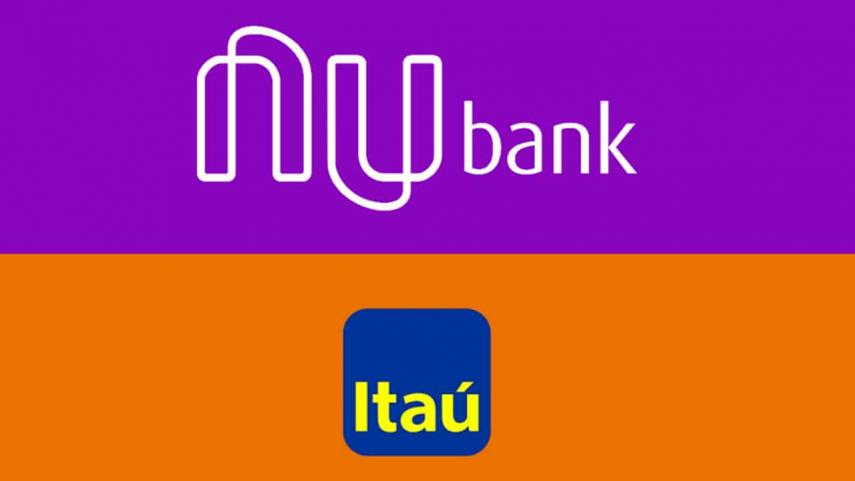

In [50]:
url_itau_nubank = 'https://braziljournal.s3.amazonaws.com/covers/d2bd16e4-0382-05d8-985f-a340a0715cab.jpg'
Image(url_itau_nubank)

In [51]:

analise_in = client.analyze_image(url_itau_nubank, visual_features=[VisualFeatureTypes.brands])

def get_brands_string(analise):
    brands = []
    for brand in analise.brands:
        brands.append({
            'name': brand.name,
            'confidence': brand.confidence,
            'rectangle': brand.rectangle
        })
    return brands

get_brands_string(analise_in)

[{'name': 'Itau Unibanco',
  'confidence': 0.647,
  'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect at 0x24328964df0>}]

Reconheceu apenas o Itaú. Ou seja, várias marcas podem não estar presentes no modelo padrão do Azure.

In [87]:
marcas = ['americanas','boticario', 'magazineluiza','CocaCola','McDonalds','Subway','iFood', 'magalu',
'xiaomi','intel','dell','submarino','Saraiva','familiaextra','itau',
'rexona','seda','loreal','garnier', 'chocolate', 'lg', 'Garoto','cacaushow','Lacta','fanta',
'guarana', 'Ambev', 'cerbeja', 'pepsi', 'subway', 'coca-cola', 'coca', 'Samsung', 'xiaomi']

In [89]:
medias = []

class ImageListener(tw.Stream):
    def on_status(self, status):
        if('media' in status.entities):
            url = status.entities['media'][0]['media_url']
            if(url not in medias):
                medias.append(url)
                analise = client.analyze_image(url, visual_features=[VisualFeatureTypes.brands])
                brands = get_brands_string(analise)
                if(len(brands) > 0):
                    print(f'Usuário: {status.user.name}')
                    print(f'Localização: {status.user.location}')    
                    print(f'Tweet: {status.text}')
                    print(f'URL: {url}')
                    
                    description = client.describe_image(url, 1, 'en')
                    print(f'Caption: {description.captions[0].text}')
                    print(f'Marcas: {brands}')
                    
                    print('\n')
                    print("*" * 100)
                    print('\n')

In [90]:
imagemStream = ImageListener(
    appsettings.consumer_key,
    appsettings.consumer_secret, 
    appsettings.access_token,
    appsettings.access_token_secret)

Documentação `tw.Stream.filter` [aqui](https://docs.tweepy.org/en/stable/stream.html#tweepy.Stream.filter).

Documentação do `Standard twitter stream API` [aqui](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/filter-realtime/guides/basic-stream-parameters).

In [93]:
def run_stream(timeout=240):
    global medias
    medias = []
    try:
        imagemStream.filter(track=marcas, languages=['pt'], threaded=True)    
        time.sleep(timeout)
    except tw.errors.TweepyException as err:
        print(err)
    finally:
        imagemStream.disconnect()

In [95]:
run_stream(timeout=240)

Stream encountered HTTP error: 406


Usuário: Laes Azeredo
Localização: Rio de Janeiro 
Tweet: RT @schincariolgabi: qual o melhor refrigerante do mundo e pq é pepsi? https://t.co/kvBgn1JWBo
URL: http://pbs.twimg.com/media/FGDQNhaWYAMKpZR.jpg
Caption: a group of cans on a counter
Marcas: [{'name': 'Pepsi', 'confidence': 0.769, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x0000024328964BE0>}]


****************************************************************************************************




Stream connection closed by Twitter
Stream encountered HTTP error: 406


Usuário: aghata៹
Localização: w madelyn cline 
Tweet: o submarino querendo fazer eu gastar o dinheiro que eu nem tenho https://t.co/kCuzRzXc11
URL: http://pbs.twimg.com/media/FGLRDwkVQAgw1WO.jpg
Caption: text
Marcas: [{'name': 'Twitter', 'confidence': 0.68, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x0000024328964FD0>}]


****************************************************************************************************




Stream encountered HTTP error: 406
Stream encountered HTTP error: 406
Stream connection has errored or timed out
Stream encountered HTTP error: 406
Stream encountered HTTP error: 406
Stream connection has errored or timed out


Usuário: Fi da Disgraça
Localização: Bahia/São Paulo
Tweet: Tudo no precinho no Ifood aqui em Salvador https://t.co/UQsNANJwVS
URL: http://pbs.twimg.com/media/FGLZg3JXsAgkaW4.jpg
Caption: graphical user interface, text, application
Marcas: [{'name': "Macy's", 'confidence': 0.636, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x0000024328964250>}]


****************************************************************************************************




Stream encountered HTTP error: 406
Stream encountered HTTP error: 406


Usuário: fefe
Localização: 📖: ddm
Tweet: vocês preferem comprar livro na submarino ou na amazon?? https://t.co/MiNzD4yUYG
URL: http://pbs.twimg.com/media/FGLbyAoWUAoQnro.jpg
Caption: icon
Marcas: [{'name': 'Apple', 'confidence': 0.676, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x00000243289CAB20>}]


****************************************************************************************************


Usuário: kyle Reese
Localização: The Sunset Strip
Tweet: O maior sonho da minha vida era tomar uma coca de 1L em praça de alimentação de shopping…hoje realizei https://t.co/1tFfJ29TrR
URL: http://pbs.twimg.com/media/FGLcQJgXEAIYpef.jpg
Caption: a bottle of soda and a plate of food on a counter
Marcas: [{'name': 'Coca-Cola', 'confidence': 0.907, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x0000024328964400>}]


**************************************************************

Stream encountered HTTP error: 406
Stream encountered an exception
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\tweepy\streaming.py", line 133, in _connect
    self.on_data(line)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tweepy\streaming.py", line 387, in on_data
    return self.on_status(status)
  File "<ipython-input-62-c294e4179226>", line 9, in on_status
    analise = client.analyze_image(url, visual_features=[VisualFeatureTypes.brands])
  File "C:\ProgramData\Anaconda3\lib\site-packages\azure\cognitiveservices\vision\computervision\operations\_computer_vision_client_operations.py", line 122, in analyze_image
    raise models.ComputerVisionErrorResponseException(self._deserialize, response)
azure.cognitiveservices.vision.computervision.models._models_py3.ComputerVisionErrorResponseException: (InvalidRequest) Image URL is not accessible.
Stream encountered HTTP error: 406
Stream encountered HTTP error: 406
Stream encountered HTTP err

### Exemplos de imagens que foram reconhecidas:

[![](https://pbs.twimg.com/media/FGDQNhaWYAMKpZR?format=jpg&name=900x900)](https://twitter.com/schincariolgabi/status/1468402429469282305)
[![](https://pbs.twimg.com/media/FGFQ78AXoAMgwN2?format=jpg&name=small)](https://twitter.com/camisasdogalo/status/1468543952546631681)

